# COMPARATIVA DE PRECISIONES

## 1. CARGA DE DATOS

In [1]:
import os
import glob
import time
import skimage.data
import skimage.transform
#import sklearn.preprocessing
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers
import pandas as pd
import csv
import math
from IPython import display

# Allow image embeding in notebook
%matplotlib inline

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_data(data_dir):
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    #print(directories)
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    
    images32 = [skimage.transform.resize(image, (32, 32))for image in images]
    
    labels2=np.array(labels)
    images2=np.array(images32)
    
    #print(label_dir)
    return images2, labels2

In [3]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir)
#print(Y_train_orig)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
def load_test_data (data_dir):
    labels  = []
    labels2 =[]
    images = []
    
    with open('GT-final_test.csv', 'r') as f:
      reader = csv.reader(f)
      labels = list(reader)
    #print(labels)
    for d in range(1,len(labels)):
        labels2.append(int(labels[d][0]))
    #print(len(labels))
    
    file_names = [os.path.join(data_dir, f) 
                  for f in os.listdir(data_dir) if f.endswith(".ppm")]
    for f in file_names:
        images.append(skimage.data.imread(f))
        
    images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
    
    labels3=np.array(labels2)
    images2=np.array(images32)
    
    return images2,labels3

In [5]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_test_data(test_data_dir)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## 1. MODELO 1

In [6]:
class Model1():
    #***BASIC MODEL WITH 1 FC LAYER***
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.logits=tf.contrib.layers.fully_connected(self.images_flat,43, tf.nn.relu)
            print(self.logits)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            self.train=tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)
        

In [7]:
def train(model, images, labels, test_images, test_labels, train_count, imprimir=True):
    #Training loop
    costs_test=[]
    acc_test=[]
    costs_train=[]
    acc_train=[]
    for i in range(train_count):
        if i % 100 == 0:
            loss_test, accuracy_test = evaluate(model, test_images, test_labels, i, imprimir)
            costs_test.append(loss_test)
            acc_test.append(accuracy_test)
            loss_train, accuracy_train = evaluate(model, images, labels, i, imprimir)
            costs_train.append(loss_train)
            acc_train.append(accuracy_train)
            if imprimir == True:
                print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(i,loss_train, accuracy_train))
                print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(i,loss_test, accuracy_test))
        
        model.session.run(model.train,{
            model.images:images,
            model.labels:labels})
            
    #Final evaluation
    loss_test, accuracy_test=evaluate(model, test_images, test_labels,i, imprimir=True)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    loss_train, accuracy_train = evaluate(model, images, labels, i, imprimir=True)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(i,loss_train, accuracy_train))
    print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(i,loss_test, accuracy_test))
    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(acc_train), label='Train')
        plt.plot(np.squeeze(acc_test), label='Test')
        plt.ylabel('Precisión')
        plt.xlabel('Iteraciones por centenares')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        plt.plot(np.squeeze(costs_test), label='Test')
        plt.ylabel('Coste')
        plt.xlabel('iteraciones por centenares')
        plt.show()

#TODO: evaluate training loss and accuracy

def evaluate(model, images, labels, step, imprimir=True):
    #Run predictions against the full test set
    #print(images.shape)
    #print(labels.shape)
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]
    #if imprimir == True:
        #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step,loss, accuracy))
    return loss, accuracy  


Tensor("fully_connected/Relu:0", shape=(?, 43), dtype=float32)
   0, Loss: 3.780  Train accuracy: 0.045
   0, Loss: 3.792  Test accuracy: 0.046
 100, Loss: 2.188  Train accuracy: 0.613
 100, Loss: 2.310  Test accuracy: 0.544
 200, Loss: 1.844  Train accuracy: 0.683
 200, Loss: 1.986  Test accuracy: 0.611
 300, Loss: 1.659  Train accuracy: 0.708
 300, Loss: 1.817  Test accuracy: 0.640
 400, Loss: 1.539  Train accuracy: 0.721
 400, Loss: 1.711  Test accuracy: 0.655
 500, Loss: 1.454  Train accuracy: 0.730
 500, Loss: 1.639  Test accuracy: 0.664
 600, Loss: 1.388  Train accuracy: 0.736
 600, Loss: 1.586  Test accuracy: 0.670
 700, Loss: 1.336  Train accuracy: 0.741
 700, Loss: 1.546  Test accuracy: 0.675
 800, Loss: 1.293  Train accuracy: 0.744
 800, Loss: 1.515  Test accuracy: 0.680
 900, Loss: 1.257  Train accuracy: 0.747
 900, Loss: 1.490  Test accuracy: 0.682
1000, Loss: 1.227  Train accuracy: 0.749
1000, Loss: 1.469  Test accuracy: 0.685
1100, Loss: 1.200  Train accuracy: 0.751
1100,

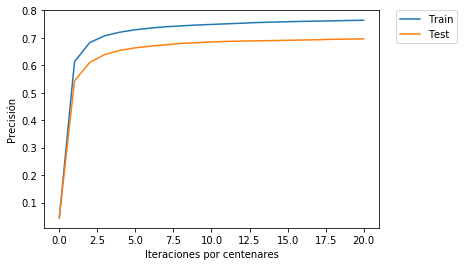

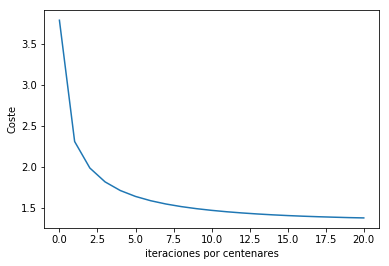

In [8]:
m1 = Model1()
train(m1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000, imprimir=True)

## 2. MODELO 2

In [ ]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

In [ ]:
class Model2():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.logits=tf.contrib.layers.fully_connected(self.images_flat,43, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [ ]:
m2 = Model2()
train_minibatch(m2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 10000, imprimir = True)

## 3. MODELO 3

In [ ]:
class Model3_1():

    def __init__(self,n1,n2,n3):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.h1=tf.contrib.layers.fully_connected(self.images_flat,n1, lrelu)
            self.h2=tf.contrib.layers.fully_connected(self.h1,n2, lrelu)
            self.logits=tf.contrib.layers.fully_connected(self.h2,n3, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [ ]:
def evaluate(model, images, labels, imprimir=True):
    #Run predictions against the full test set
    #print(images.shape)
    #print(labels.shape)
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]

    return loss, accuracy 

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs_test=[]
    acc_test=[]
    costs_train=[]
    acc_train=[]
    for i in range(train_counts):
        if i % 50 == 0:
            loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
            costs_test.append(loss_test)
            acc_test.append(accuracy_test)
            loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
            costs_train.append(loss_train)
            acc_train.append(accuracy_train)
            a = model.session.run(model.global_step)
            if imprimir == True:
                print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
                print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
        # ??? improve picking batches
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    
    loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    
    print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
    print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
    
    prec_max=max(acc_train)
    prec_max_local = 0
    b = 0
    #print('prec_max',prec_max)
    
    while prec_max > prec_max_local:
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})

        loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
        #if imprimir == True:
            #print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(a,loss_train, accuracy_train))
            #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(a,loss_test, accuracy_test))
        
        prec_max_local = accuracy_train
        #print(prec_max_local)
        if b > 1000:
            
            break
            
        
        b += 1
        #print('a',b)
        
    loss_test, accuracy_test = evaluate(model, test_images, test_labels, imprimir)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    loss_train, accuracy_train = evaluate(model, images, labels, imprimir)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(acc_train), label='Entr.')
        plt.plot(np.squeeze(acc_test), label='Valid.')
        plt.ylabel('Precisión')
        plt.xlabel('Iteraciones por decenas')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
        plt.plot(np.squeeze(costs_test), label='Test')
        plt.ylabel('Coste')
        plt.xlabel('iteraciones por decenas')
        plt.show()
    
    return costs_train, acc_train, costs_test, acc_test       

In [ ]:
m3_1=Model3_1(300,100,43)
M3_1 = train_minibatch(m3_1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 5000, imprimir=True)

## 4. MODELO 4

In [ ]:
from tensorflow.contrib import layers
import time

In [ ]:
class Model4():
    def conv(self, input, num_outputs, name=None):
        return layers.convolution2d(
            input, num_outputs=num_outputs, kernel_size=(5,5), stride=(1,1),
            padding='SAME', activation_fn=lrelu, normalizer_fn=layers.batch_norm
            )
    def pool(self, input):
        return layers.max_pool2d(input, kernel_size=(2,2),
                                stride=(2,2), padding='SAME')
    def __init__(self):
        #History of training state as tuples (step, loss, accuracy, training loss, time)
        self.train_log =[]
        self.train_time=[]
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global step counter
            self.global_step = tf.Variable(0, trainable=False, name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32, (None, 32,32,3), name='images')
            self.labels=tf.placeholder(tf.int32, (None), name='labels')
            #Block input shape [32,32,3], output shape [16,16,16]
            self.conv1 = self.conv(self.images,8)
            self.pool1=self.pool(self.conv1)
            #Block input shape: [16,16,16], output shape [8,8,32]
            self.conv2=self.conv(self.pool1,12)
            self.pool2=self.pool(self.conv2)
            #Block input shape: [8,8,32], ouutput shpae [4,4,64]
            self.conv3=self.conv(self.pool2,16)
            self.pool3=self.pool(self.conv3)
            #Fully connected layer
            self.flat=layers.flatten(self.pool3)
#            self.hl=layers_fully:connected(sefl.flat,200,lrelu)
            #self.shapeflat=self.flat.shape
            self.logits = layers.fully_connected(self.flat,43,lrelu)
            #Convert one hot vector to label index
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training OP
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                                .minimize(self.loss, global_step=self.global_step)
            #Initialization Op
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run initialization Op
            self.session.run(self.init)

In [ ]:
def train_graph(model, train_images, train_labels, val_images, Val_labels, train_count, imprimir=True):
    t_start=time.time()
    #Training loop
    for i in range(1, train_count+1):
        ##??? improve picking batches
        #COGEMOS UN PEQUEÑO BATCH DE 100 IMAGENES RANDOM
        indexes = np.random.choice(np.arange(train_images.shape[0]),100,replace=False)
        batch_images=train_images[indexes]
        batch_labels=train_labels[indexes]
        #ENTRENAMOS ESTE BATCH CON NUESTRO MODELO
        _, loss = model.session.run([model.train, model.loss], {
            model.images:batch_images,
            model.labels:batch_labels,
            })
        # Evaluate
        if i % 50 == 0:
            evaluate_graph(model, batch_images, batch_labels, val_images, Val_labels, t_start)
    #Final evalution
    evaluate_graph(model, batch_images, batch_labels, val_images, Val_labels, t_start, imprimir=True)
    #shape = model.session.run([model.shapeflat], {
    #        model.images:batch_images,
    #        model.labels:batch_labels,
    #        })
    #print(shape)

def evaluate_graph(model, train_images, train_labels, val_images, val_labels, training_time, imprimir=False):
    #Run predicionts against a batch of the training set
    train_predicted, train_loss, step = model.session.run(
        [model.predicted_labels, model.loss, model.global_step],
        {model.images:train_images, model.labels:train_labels})
    
    #Run predictions against the full test set
    val_predicted, val_loss = model.session.run(
            [model.predicted_labels, model.loss],
            {model.images: val_images, model.labels:val_labels})
    
    #Calculate accuracy
    train_accuracy=np.sum(train_labels == train_predicted) / train_labels.shape[0]
    val_accuracy = np.sum(val_labels == val_predicted) / val_labels.shape[0]
    #Append to train log
    model.train_log.append((step, train_loss, train_accuracy, val_loss, val_accuracy, training_time))
    #Plot
    draw_graph(model.train_log)
    
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Train set accuracy: {:.3f}".format(step,train_loss, train_accuracy))
        print("{:4}, Loss: {:.3f}  Validation set accuracy: {:.3f}".format(step ,val_loss, val_accuracy))

def draw_graph(logs):
    #Expand log tuples to lists
    steps, train_losses, train_accuracies, val_losses, val_accuracies, times = zip(*logs)
    #Clear output
    display.clear_output(wait=True)
    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(8,6))
    #Graph 1: Accuracies
    ax1.set_title("Step: {}     Training Time:  {:.0f}  seconds\n"\
                  "Training Accuracy: {:.3f}    Validation Accuracy: {:.3f}"\
                  .format(steps[-1], times[-1], train_accuracies[-1], val_accuracies[-1]), 
                  fontsize=5)
    ax1.plot(steps, train_accuracies, label="Training Accuray")
    ax1.plot(steps, val_accuracies, label="Validation Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(fontsize=8, loc="lower right")
#    ax1.set_y1(0,1.1)
    #Graph 2 : Losses
    ax2.set_title("Training loss: {:.3f} Validation Loss: {:.3}"\
                 .format(train_losses[-1],val_losses[-1]),fontsize=5)
    ax2.set_yscale('log')
    ax2.plot(steps, train_losses, label="Training loss")
    ax2.plot(steps,val_losses, label="Validation Loss")
    ax2.set_ylabel("Loss")
    ax2.legend(fontsize=8, loc='lower left')
    ax2.set_xlabel("Steps")
    _ = plt.show()

In [ ]:
m4=Model4()

In [ ]:
train_graph(m4, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 2000)